In [2]:
import pandas as pd
import os 
import matplotlib.pyplot as plt 
import re
import numpy as np
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
# For bokeh visualisations
from bokeh.plotting import figure
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import show, output_notebook, reset_output
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.layouts import row

In [3]:
# load tree data 
df = pd.read_csv("data/df_tree.csv")
df.year = df.year.apply(int)
df.id = df.id.astype("category")

# Plots til punkt 1

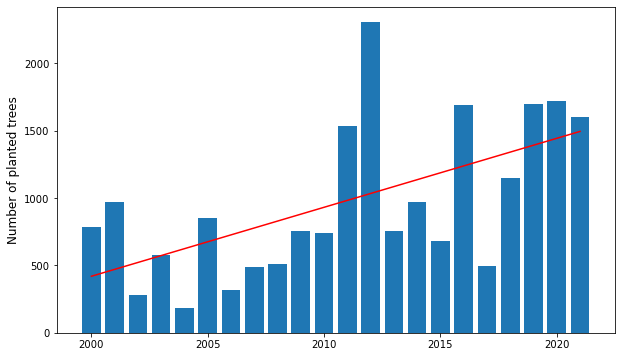

In [4]:
# Are there in general more trees planted over time?
from scipy import stats
df_year = df.groupby(['year']).size()
# for trend curve
slope, intercept, r_value, p_value, std_err = stats.linregress(df_year.index.to_list(),df_year.values)

plt.figure(figsize=(10,6))
plt.bar(df_year.index,df_year.values)
plt.plot(df_year.index, slope*(df_year.index) + intercept, 'r-')
plt.ylabel('Number of planted trees',fontsize=12)
plt.show()

In [10]:
# Line plot showing trees planted per km2 in each district from 2000 to 2021 
df_genial = pd.read_csv('data/df_genial.csv')
df_grøn = df_genial[['year','district','trees_km2']]
df_km2_year = pd.pivot_table(df_grøn, values='trees_km2', index='year', columns=['district'], fill_value=0)


df_districts = df.groupby(["year", "district"]).size().reset_index()
districts = df_districts.district.unique()

# BOKEH 


reset_output() # If you are having issues with visualizing Bokeh plots in the notebook try to uncomment this line
# prepare data for bokeh plot
#Create empty figures

p1 = figure(plot_width = 900, plot_height = 600, title = "Number of trees planted per km2 for each district", 
            x_axis_label = "Year", y_axis_label = "Number of trees per km2") 


#colors
colors = ["red", "blue", "green", "cyan", "black", "darkblue", "magenta", "yellow", "orange", "grey"]
#Create empty list for custom legend
items1 = []

#Add line by using p.line
line ={}
# Pivot table for number of unique species in each district over the years 
df_km2_year = pd.pivot_table(df_grøn, values='trees_km2', index='year', columns=['district'], fill_value=0)

# Insert fraction values in bars
for indx, i in enumerate(districts):
    line[indx] = p1.line(x=df_km2_year.index, y = df_km2_year[i], width=1.5, color = colors[indx], muted =True)
    #Append items to create the legend
    items1.append((districts[indx], [line[indx]]))


#This is to manage the legend in plot
#add the legend outside the plot
legend = Legend(items=items1, location="top_left")
p1.add_layout(legend, 'left')

p1.legend.click_policy = "mute" #you can also try "hide"
p1.title.text_font_size = "20px"


output_notebook()
show(p1)

Loading BokehJS ...

In [13]:
# Get dataframe with values needed for plot of unique species for each district
df_species = df.groupby(['year','district','species']).count()
df_species =  df_species.reset_index()

reset_output() # If you are having issues with visualizing Bokeh plots in the notebook try to uncomment this line
# prepare data for bokeh plot
#Create empty figures

p1 = figure(plot_width = 900, plot_height = 600, title = "Number of unique species planted for each district", 
            x_axis_label = "Year", y_axis_label = "Number of unique species planted") 


#colors
colors = ["red", "blue", "green", "cyan", "black", "darkblue", "magenta", "yellow", "orange", "grey"]
#Create empty list for custom legend
items1 = []

#Add line by using p.line
line ={}
# Pivot table for number of unique species in each district over the years 
df_species_year = pd.pivot_table(df_species, values='species', index='year', columns=['district'], aggfunc='nunique', fill_value=0)

# Insert fraction values in bars
for indx, i in enumerate(districts):
    line[indx] = p1.line(x=df_species_year.index, y = df_species_year[i], width=1.5, color = colors[indx], muted =True)
    #Append items to create the legend
    items1.append((districts[indx], [line[indx]]))


#This is to manage the legend in plot
#add the legend outside the plot
legend = Legend(items=items1, location="top_left")
p1.add_layout(legend, 'left')

p1.legend.click_policy = "mute" #you can also try "hide"
p1.title.text_font_size = "20px"


output_notebook()
show(p1)

#show(tabs)

Loading BokehJS ...

In [12]:
# Function to create a bar chart of top 10 species for each district in tabs.
def stacked_bar_chart(dataframe, title, use_district):
    # Find the specific district and remove non registered
    temp = dataframe.loc[df['district'] == use_district]
    temp = temp[temp.species != "Ikke registreret"]
    # Find top 10 species for the specific district
    temp2 = temp.groupby(["district", 'species']).size().sort_values(ascending=False)[0:10].reset_index(name='counts')
    temp3 = temp2.pivot_table('counts',["species"], 'district')
    temp3.columns = [''.join(col) for col in temp3.columns]
    temp3.rename(columns={use_district: "count"}, inplace = True)
    # Make it ready for bokeh plot
    temp3 = temp3.reset_index()
    temp3 = temp3.sort_values(by='count', ascending=False)
    
    # Convert pandas df to ColumnDataSource
    src = ColumnDataSource(temp3)
    
    #Create empty figures
    p = figure(plot_width = 900, plot_height = 600, title = title,
            x_axis_label = "species", y_axis_label = "n_samples", x_range= temp3["species"]) 


    #Define the columns to use for each bar
    bar_cols = ["count"]
    colors = ["red"]
    #Create empty list for custom legend
    items = []

    #Add bars by using p.var
    bar ={}
    # Insert fraction values in bars
    for indx, i in enumerate(bar_cols):
        bar[i] = p.vbar(x="species", top = i, source= src, width=0.5, color=colors[indx], muted =True)
        #Append items to create the legend
        items.append((bar_cols[indx], [bar[i]]))
    

    #This is to manage the legend in plot
    #p.legend.visible = True
    #add the legend outside the plot
    legend = Legend(items=items, location="top_left")
    p.add_layout(legend, "left")
    p.legend.click_policy = "mute" #you can also try "hide"

    return p

In [271]:
# Visualize all 10 district and the count of their top 10 species
tab1 = Panel(child=stacked_bar_chart(df, 'Number of samples by species', 'Amager Vest'), title="Amager Vest")
tab2 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Amager Øst'), title="Amager Øst")
tab3 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Bispebjerg'), title="Bispebjerg")
tab4 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Brønshøj-Husum'), title="Brønshøj-Husum")
tab5 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Indre By'), title="Indre By")
tab6 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Nørrebro'), title="Nørrebro")
tab7 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Valby'), title="Valby")
tab8 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Vanløse'), title="Vanløse")
tab9 = Panel(child=stacked_bar_chart(df, 'Number of samples by species','Vesterbro-Kongens Enghave'), title="Vesterbro-Kongens Enghave")
tab10 =Panel(child=stacked_bar_chart(df, 'Number of samples by species','Østerbro'), title="Østerbro")
tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4, tab5, tab6, tab7, tab8, tab9, tab10])
show(tabs)

# Punkt 5


In [14]:
# Bokeh
reset_output()

df_type = df.groupby(["district", "type"]).size().reset_index()
df_type = df_type.pivot_table(0,["district"], 'type')
df_type.columns = [''.join(col) for col in df_type.columns]
df_type = df_type.drop(["0"], axis=1)
df_type = df_type.fillna(0)
df_type = df_type.reset_index()
src = ColumnDataSource(df_type)
    
#Create empty figures
p = figure(plot_width = 900, plot_height = 700, title = "n_type_of_tree",
    x_axis_label = "District", y_axis_label = "n_samples", x_range= df_type["district"]) 


#Define the columns to use for each bar
bar_cols = ["Formede Træer", "Gade- og allétræer", "Park- og naturtræer", "Private træer", "Træer i bevoksninger"]
colors = ["black", "blue", "green", "magenta", "orange"]
#Create empty list for custom legend
items = []

#Add bars by using p.var
bar ={}
# Insert fraction values in bars
bar = p.vbar_stack(bar_cols, x= "district", source= src, width=0.5, legend_label=bar_cols, color=colors, muted =True)
# for indx, i in enumerate(bar_cols):
#     bar[i] = p.vbar(x="district", top = i, source= src, width=0.5, legend_label=i, color=colors[indx], muted =True)
#     #Append items to create the legend
#items.append((bar_cols, bar))


#This is to manage the legend in plot
p.legend.visible = True
p.legend.location = "top_left"
#add the legend outside the plot
# legend = Legend(items=items, location="top_left")
# p.add_layout(legend, "left")
p.legend.click_policy = "mute" #you can also try "hide"
p.xaxis.major_label_orientation = np.math.pi/2
output_notebook()
show(p)

Loading BokehJS ...

In [34]:
# Heat map showing planted years over time
df_heatmap = df[df['year']>2007]
df_heatmap_nørrebro = df_heatmap[df_heatmap['district'] == 'Nørrebro']

heat_data = pd.DataFrame()
heat_data[['Y','X', "Weight"]] = df_heatmap_nørrebro[['Y','X', "year"]]
heat_data['Weight'] = heat_data['Weight'].astype(float)
heat_data = heat_data.dropna(axis=0, subset=['Y','X', 'Weight'])
heat_data = [[[row['Y'],row['X']] for index, row in heat_data[heat_data['Weight'] == i].iterrows()] for i in range(2008,2021)]

# gps coordinates for Nørrebros runddel 
lat = 55.692108154296875
lon = 12.552446365356445
map = folium.Map(location=[lat, lon],zoom_start = 14)
hm = HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map)
map

2012: stop at 5, trees planted in mimersparken and superkilen. 
Mimersparken: park mellem Bispebjerg station og mjølnerparken. Åbnet i 2012. https://da.wikipedia.org/wiki/Mimersparken
Superkilen: park mellem Mimersgade og Tagensvej, åbnet i 2012. https://da.wikipedia.org/wiki/Superkilen

In [35]:
df_heatmap_østerbro = df_heatmap[df_heatmap['district'] == 'Østerbro']

heat_data = pd.DataFrame()
heat_data[['Y','X', "Weight"]] = df_heatmap_østerbro[['Y','X', "year"]]
heat_data['Weight'] = heat_data['Weight'].astype(float)
heat_data = heat_data.dropna(axis=0, subset=['Y','X', 'Weight'])
heat_data = [[[row['Y'],row['X']] for index, row in heat_data[heat_data['Weight'] == i].iterrows()] for i in range(2008,2021)]

# Plot it on the map
lat = 55.7075777778
lon = 12.5688722222
map = folium.Map(location=[lat, lon],zoom_start = 13)
hm = HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map)
map

2012: stop at 5. Trees planted in Fælledparken and Klosterfælleden. 